In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

---

**Рассмотрим уже знакомый нам датасет с фильмами номинантами на оскар.**

Предположим перед нами стоит задача построения модели предсказания вероятности взятия оскара тем или иным фильмом по известной информации из таблицы

In [2]:
oscars = pd.read_csv('sem_2_oscars_df.csv', index_col=0)

In [3]:
oscars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571 entries, 0 to 570
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Film                              571 non-null    object 
 1   Oscar Year                        571 non-null    object 
 2   Film Studio/Producer(s)           571 non-null    object 
 3   Award                             571 non-null    object 
 4   Year of Release                   571 non-null    int64  
 5   Movie Time                        571 non-null    int64  
 6   Movie Genre                       571 non-null    object 
 7   IMDB Rating                       571 non-null    float64
 8   IMDB Votes                        571 non-null    object 
 9   Movie Info                        438 non-null    object 
 10  Genres                            439 non-null    object 
 11  Critic Consensus                  339 non-null    object 
 12  Content 

In [4]:
oscars.Award.unique()

array(['Winner', 'Nominee'], dtype=object)

То есть для каждого примера фильма с вышеописанными характеристиками мы бы хотели предсказывать с какой вероятностью поле `Award == Winner` 

---

В первую очередь взглянем на общую природу данных:

In [5]:
oscars.describe(include='object')

,Film,Oscar Year,Film Studio/Producer(s),Award,Movie Genre,IMDB Votes,Movie Info,Genres,Critic Consensus,Content Rating,Directors,Authors,Actors,Original Release Date,Streaming Release Date,Production Company,Tomatometer Status,Audience Status,Film ID
count,571,571,571,571,571,571,438,439,339,439,437,437,439,439,438,439,439,436,571
unique,564,93,378,2,128,570,438,107,339,5,262,397,439,420,214,104,3,2,571
top,Mutiny on the Bounty,1935,Metro-Goldwyn-Mayer,Nominee,"Drama,Romance","147,893","In May 1940, Germany advanced into France, tra...",Drama,Humphrey Bogart is superb as a domineering cap...,R,William Wyler,Ernest Lehman,"Katharine Hepburn, Ginger Rogers, Adolphe Menj...",1942-01-01,2012-04-16,Paramount Pictures,Certified-Fresh,Upright,111025ab-00c2-490a-8921-f298fe1a6006
freq,2,12,40,478,62,2,1,78,1,138,11,5,1,3,35,33,263,417,1


Сразу заметим, что для некоторых фильмов существует несколько строк в таблице
Разберемся, что это за строки

In [6]:
values, counts = np.unique(oscars.Film, return_counts=True)
non_unique_films = values[counts > 1]

In [7]:
oscars[np.in1d(oscars.Film, non_unique_films)].sort_values('Film')

,Film,Oscar Year,Film Studio/Producer(s),Award,Year of Release,Movie Time,Movie Genre,IMDB Rating,IMDB Votes,Movie Info,...,Tomatometer Status,Tomatometer Rating,Tomatometer Count,Audience Status,Audience Rating,Audience Count,Tomatometer Top Critics Count,Tomatometer Fresh Critics Count,Tomatometer Rotten Critics Count,Film ID
79,A Star Is Born,1937,Selznick International Pictures,Nominee,1937,111,"Drama,Romance",7.3,"9,301",When a young actress (Janet Gaynor) arrives in...,...,Fresh,100.0,20.0,Upright,78.0,2686.0,5.0,20.0,0.0,ea80da77-0642-48c5-a2eb-1d03fb856d2f
552,A Star Is Born,2018,"Bill Gerber, Bradley Cooper, and Lynette Howel...",Nominee,2018,136,"Drama,Music,Romance",7.6,"354,157",Seasoned musician Jackson Maine discovers -- a...,...,Certified-Fresh,90.0,517.0,Upright,79.0,20442.0,62.0,466.0,52.0,a8a00610-8b95-4d5f-b95e-128b6a2853ea
38,Cleopatra,1934,Paramount,Nominee,1934,100,"Biography,Drama,History",6.8,"3,678",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30a8cacf-0902-4d8c-9c02-934c09e284a6
237,Cleopatra,1963,Walter Wanger,Nominee,1963,192,"Biography,Drama,History",7.0,"31,027","""Cleopatra"" is a lengthy, sprawling, spectacul...",...,Fresh,62.0,39.0,Upright,69.0,20541.0,10.0,24.0,15.0,47a31f2d-67c9-4aa1-a336-6f30e4dc6c57
132,Heaven Can Wait,1943,20th Century-Fox,Nominee,1943,112,"Comedy,Drama,Fantasy",7.4,"10,272",Spoiled playboy Henry van Cleve (Don Ameche) d...,...,Fresh,85.0,13.0,Upright,75.0,4380.0,2.0,11.0,2.0,7694bb35-bd99-4b9f-8616-e3c1c0462484
312,Heaven Can Wait,1978,Warren Beatty,Nominee,1978,101,"Comedy,Fantasy,Romance",6.9,"19,822","Joe Pendleton (Warren Beatty), quarterback for...",...,Certified-Fresh,88.0,41.0,Upright,68.0,13232.0,8.0,36.0,5.0,8f0dd2a2-3322-4372-af45-cf1940585d86
56,Les Misérables,1935,20th Century,Nominee,1935,108,"Drama,History,Romance",7.7,"3,468",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,521b9bf2-426b-49a1-aeb3-d228db8a970c
500,Les Misérables,2012,"Tim Bevan, Eric Fellner, Debra Hayward, and Ca...",Nominee,2012,158,"Drama,History,Musical",7.6,"317,030","After 19 years as a prisoner, Jean Valjean (Hu...",...,Fresh,69.0,255.0,Upright,79.0,265259.0,49.0,177.0,78.0,d7ede1ef-73aa-4ffe-8d0e-254b90588f95
31,Little Women,1932/33,RKO Radio,Nominee,1933,115,"Drama,Family,Romance",7.2,"6,778",The endearing saga of the March sisters -- Meg...,...,Fresh,94.0,16.0,Upright,78.0,9776.0,3.0,16.0,2.0,f6fa2e25-588d-414f-a59d-67b9eb033270
560,Little Women,2019,Amy Pascal,Nominee,2019,135,"Drama,Romance",7.8,"163,410",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6207f4ff-c6a8-4922-b48d-71b03a01bc96


Как мы видим, несмотря на то, что названия у фильмов одинаковое - года выпуска разные, что успокаивает наши переживания на наличие каких-либо дублей в данных и позволяет работать со всеми строками как уникальными фильмами

---

In [8]:
oscars.head()

,Film,Oscar Year,Film Studio/Producer(s),Award,Year of Release,Movie Time,Movie Genre,IMDB Rating,IMDB Votes,Movie Info,...,Tomatometer Status,Tomatometer Rating,Tomatometer Count,Audience Status,Audience Rating,Audience Count,Tomatometer Top Critics Count,Tomatometer Fresh Critics Count,Tomatometer Rotten Critics Count,Film ID
0,Wings,1927/28,Famous Players-Lasky,Winner,1927,144,"Drama,Romance,War",7.5,"12,221","With World War I afoot, David Armstrong (Richa...",...,Certified-Fresh,93.0,46.0,Upright,78.0,3530.0,9.0,43.0,3.0,2becf7d5-a3de-46ab-ae45-abdd6b588067
1,7th Heaven,1927/28,Fox,Nominee,1927,110,"Drama,Romance",7.7,"3,439",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19ed3295-a878-4fd2-8e60-5cd7b5f93dad
2,The Racket,1927/28,The Caddo Company,Nominee,1928,84,"Crime,Drama,Film-Noir",6.7,"1,257",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3111c2d8-0908-4093-8ff3-99c89f2f2f08
3,The Broadway Melody,1928/29,Metro-Goldwyn-Mayer,Winner,1929,100,"Drama,Musical,Romance",5.7,"6,890","Vaudeville sisters ""Hank"" (Bessie Love) and Qu...",...,Rotten,33.0,24.0,Spilled,21.0,1813.0,7.0,8.0,16.0,de063f3f-2d35-4e1c-8636-6eb4c16bd236
4,Alibi,1928/29,Feature Productions,Nominee,1929,91,"Action,Crime,Romance",5.8,765,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,609887c2-877c-43a4-b88c-e40e31096a98


In [9]:
oscars.describe(include='object')

,Film,Oscar Year,Film Studio/Producer(s),Award,Movie Genre,IMDB Votes,Movie Info,Genres,Critic Consensus,Content Rating,Directors,Authors,Actors,Original Release Date,Streaming Release Date,Production Company,Tomatometer Status,Audience Status,Film ID
count,571,571,571,571,571,571,438,439,339,439,437,437,439,439,438,439,439,436,571
unique,564,93,378,2,128,570,438,107,339,5,262,397,439,420,214,104,3,2,571
top,Mutiny on the Bounty,1935,Metro-Goldwyn-Mayer,Nominee,"Drama,Romance","147,893","In May 1940, Germany advanced into France, tra...",Drama,Humphrey Bogart is superb as a domineering cap...,R,William Wyler,Ernest Lehman,"Katharine Hepburn, Ginger Rogers, Adolphe Menj...",1942-01-01,2012-04-16,Paramount Pictures,Certified-Fresh,Upright,111025ab-00c2-490a-8921-f298fe1a6006
freq,2,12,40,478,62,2,1,78,1,138,11,5,1,3,35,33,263,417,1


In [10]:
oscars['Oscar Year'].unique()

array(['1927/28', '1928/29', '1929/30', '1930/31', '1931/32', '1932/33',
       '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941',
       '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949',
       '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957',
       '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965',
       '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981',
       '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
      dtype=object)

Заметим, что у нас есть несколько примеров фильмов, у которых год номинации парный.
Давайте, не умоляя общности, (в силу ежегодности проведения мероприятия) опустим вторую часть даты у этих примеров и приведем даты к одному формату

In [11]:
oscars['Oscar Year'].apply(lambda year_r: year_r.split('/')[0])

0      1927
1      1927
2      1927
3      1928
4      1928
       ... 
566    2020
567    2020
568    2020
569    2020
570    2020
Name: Oscar Year, Length: 571, dtype: object

In [12]:
oscars['Oscar Year'] = oscars['Oscar Year'].apply(lambda year_r: year_r.split('/')[0])

---

В качестве разминки мы обработали одну фичу
Давайте теперь подойдем к вопросу работы с данными чуть более системно

Разобьем факторы на разные группы и поработаем с ними отдельно

In [13]:
SIMPLE_CAT_FEATURES = [
    'Content Rating',
    'Tomatometer Status',
    'Audience Status',
]
CAT_FEATURES = [
    'Film Studio/Producer(s)',
    'Production Company',
]
MULTILABEL_FEATURES = [
    'Movie Genre',
    'Genres',
    'Directors',
    'Authors',
    'Actors',
]
TEXT_FEATURES = [
    'Film',
    'Movie Info',
    'Critic Consensus',
]
DATE_FEATURES = [
    'Oscar Year',
    'Year of Release',
    'Original Release Date',
    'Streaming Release Date',
]
DIGIT_FEATURES = [
    'Movie Time',
    'IMDB Rating',
    'IMDB Votes',
    'Tomatometer Rating',
    'Tomatometer Count',
    'Audience Rating',
    'Audience Count',
    'Tomatometer Top Critics Count',
    'Tomatometer Fresh Critics Count',
    'Tomatometer Rotten Critics Count',
]
# Auxiliary
AUX_FEATURES = [
    'Award',
    'Film ID',
]


# Плохой пример как не стоит проверять два множества на совпадение:
if (np.unique(
    SIMPLE_CAT_FEATURES
    + CAT_FEATURES
    + MULTILABEL_FEATURES
    + TEXT_FEATURES
    + DATE_FEATURES
    + DIGIT_FEATURES
    + AUX_FEATURES
) != np.unique(oscars.columns)).all():
    raise RuntimeError
    
# А не падает этот пример, потому что у np.unique есть гарантия на лексикографический порядок выданных значений
# но если вы уберете хотя бы одну колонку из списков выше, то забавно, что код упадет не по RuntimeError,
# а по экспешену в заголовке IF

### Simple Categorical Features

В первую очередь рассмотрим простой случай:


Категориальные факторы с очень маленьким числом значений

In [14]:
oscars[SIMPLE_CAT_FEATURES].describe(include='object')

,Content Rating,Tomatometer Status,Audience Status
count,439,439,436
unique,5,3,2
top,R,Certified-Fresh,Upright
freq,138,263,417


In [15]:
oscars[SIMPLE_CAT_FEATURES]

,Content Rating,Tomatometer Status,Audience Status
0,PG-13,Certified-Fresh,Upright
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NR,Rotten,Spilled
4,NaN,NaN,NaN
...,...,...,...
566,NaN,NaN,NaN
567,NaN,NaN,NaN
568,NaN,NaN,NaN
569,NaN,NaN,NaN


Положим в качестве пропуска Yet Another категорию

Обзовем ее здесь и далее `UNK` (`Unknown`)

In [16]:
NAN_VAL = 'UNK'


oscars[SIMPLE_CAT_FEATURES] = oscars[SIMPLE_CAT_FEATURES].fillna(NAN_VAL)

In [17]:
oscars[SIMPLE_CAT_FEATURES].head()

,Content Rating,Tomatometer Status,Audience Status
0,PG-13,Certified-Fresh,Upright
1,UNK,UNK,UNK
2,UNK,UNK,UNK
3,NR,Rotten,Spilled
4,UNK,UNK,UNK


---

In [18]:
def draw_cat_freqs(data, column):
    values, counts = np.unique(data[column], return_counts=True)
    
    plt.figure(figsize=(12, 8))
    plt.bar(values, counts, alpha=0.5)
    plt.grid()
    plt.title(f'{column} frequencies')

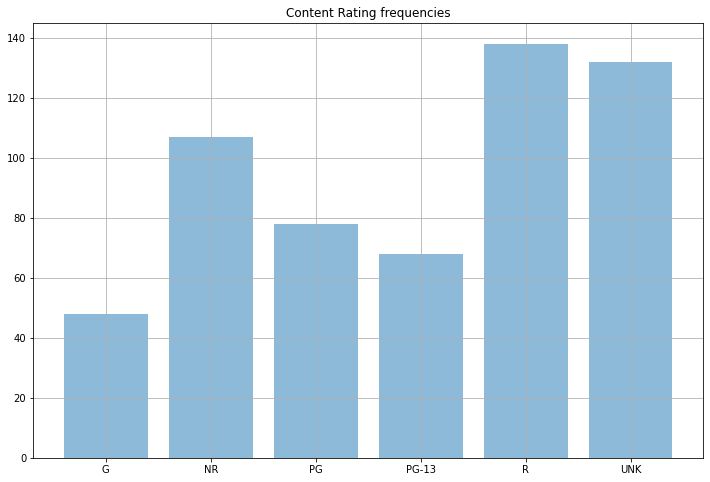

In [19]:
draw_cat_freqs(oscars, 'Content Rating')

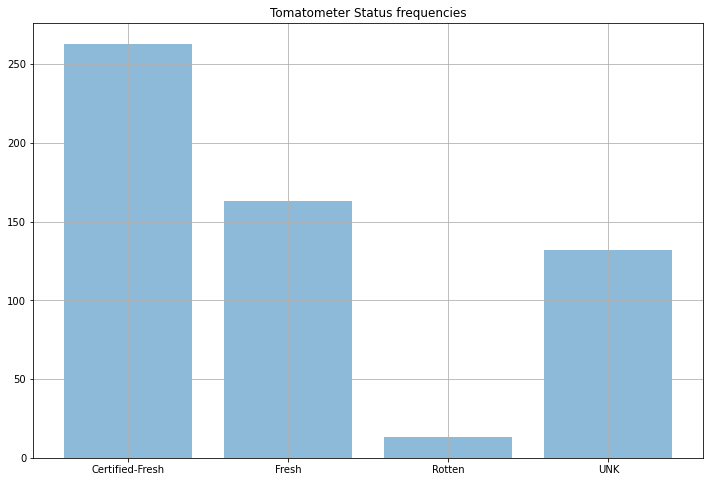

In [20]:
draw_cat_freqs(oscars, 'Tomatometer Status')

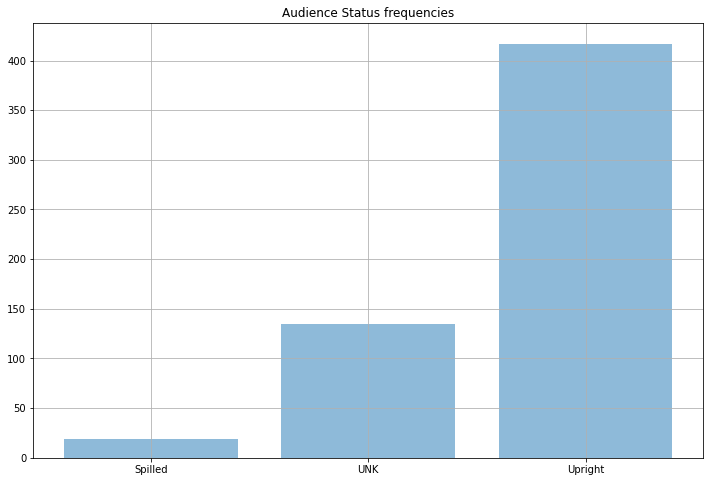

In [21]:
draw_cat_freqs(oscars, 'Audience Status')

### Categorical Features

В этом случае чуть сложнее

Кол-во уникальных значений у факторов такого же порядка сколько и строк в датасете
Давайте заполним пропуски и оставим только топ-несколько категорий
Чтобы после OneHot-кодирования не раздувать наш датасет

Более того, маломощные категория вряд ли являются информативными, поэтому лучше мы их все сгруппируем в одну категорию `_rest`

In [22]:
oscars[CAT_FEATURES].head()

,Film Studio/Producer(s),Production Company
0,Famous Players-Lasky,Unknown
1,Fox,NaN
2,The Caddo Company,NaN
3,Metro-Goldwyn-Mayer,MGM Home Entertainment
4,Feature Productions,NaN


In [23]:
oscars[CAT_FEATURES].describe(include='object')

,Film Studio/Producer(s),Production Company
count,571,439
unique,378,104
top,Metro-Goldwyn-Mayer,Paramount Pictures
freq,40,33


In [24]:
oscars.loc[
    oscars['Production Company'] == 'Unknown',
    'Production Company'
] = NAN_VAL

In [25]:
oscars[CAT_FEATURES] = oscars[CAT_FEATURES].fillna(NAN_VAL)

---

In [26]:
def topk_freqs(data, column, k=20):
    values, counts = np.unique(data[column], return_counts=True)
    
    idxs = np.argsort(counts)[-k:]
    return values[idxs], counts[idxs]

    
def _draw_topk_freqs(values, counts, k=20, title=''):
    idxs = np.argsort(counts)[-k:]
    
    plt.figure(figsize=(12, 8))
    plt.bar(values[idxs], counts[idxs], alpha=0.5)
    plt.xticks(rotation=45)
    plt.grid()
    plt.title(title)
    
def draw_topk_freqs(data, column, k=20):
    values, counts = topk_freqs(data, column, k)
    
    _draw_topk_freqs(values, counts, k, title=f'Top{k} {column} frequencies')
    
    
def merge_lowfreq_cats(data, column, k=20, token='_rest'):
    values, counts = np.unique(data[column], return_counts=True)
    
    rest_values = values[np.argsort(counts)[:-k + 1]]
    data.loc[
        np.in1d(data[column], rest_values),
        column
    ] = token

In [27]:
REST_VAL = '_rest'

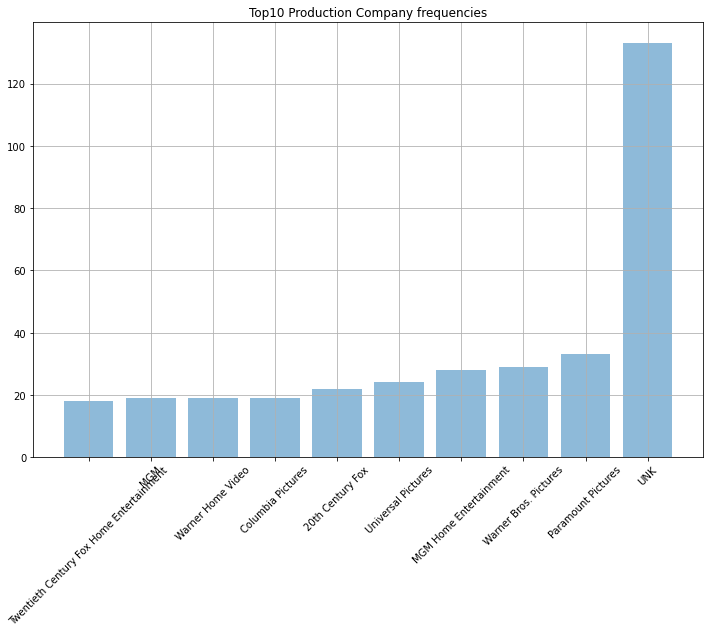

In [28]:
draw_topk_freqs(oscars, 'Production Company', 10)
merge_lowfreq_cats(oscars, 'Production Company', 10, REST_VAL)

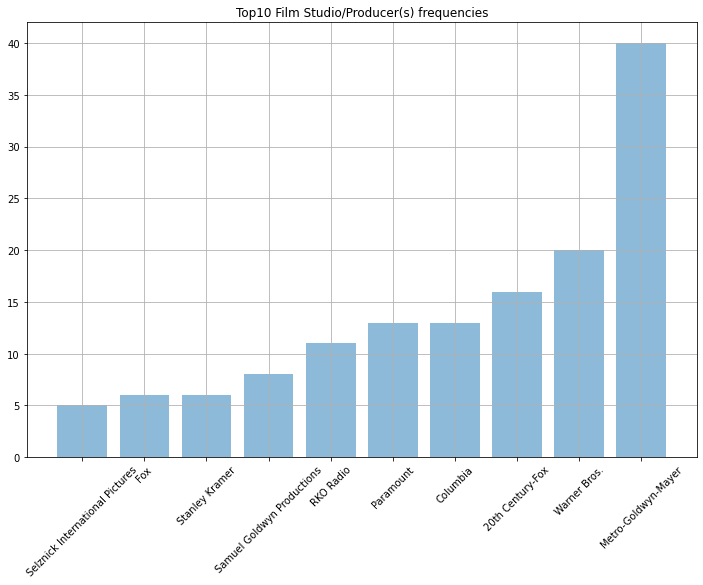

In [29]:
draw_topk_freqs(oscars, 'Film Studio/Producer(s)', 10)
merge_lowfreq_cats(oscars, 'Film Studio/Producer(s)', 10, REST_VAL)

In [30]:
oscars[CAT_FEATURES]

,Film Studio/Producer(s),Production Company
0,_rest,UNK
1,Fox,UNK
2,_rest,UNK
3,Metro-Goldwyn-Mayer,MGM Home Entertainment
4,_rest,UNK
...,...,...
566,_rest,UNK
567,_rest,UNK
568,_rest,UNK
569,_rest,UNK


In [31]:
oscars[CAT_FEATURES].describe(include='object')

,Film Studio/Producer(s),Production Company
count,571,571
unique,10,10
top,_rest,_rest
freq,438,245


### Date Features

In [32]:
oscars[DATE_FEATURES]

,Oscar Year,Year of Release,Original Release Date,Streaming Release Date
0,1927,1927,1927-08-12,2017-01-02
1,1927,1927,NaN,NaN
2,1927,1928,NaN,NaN
3,1928,1929,1929-02-01,2017-02-25
4,1928,1929,NaN,NaN
...,...,...,...,...
566,2020,2020,NaN,NaN
567,2020,2020,NaN,NaN
568,2020,2020,NaN,NaN
569,2020,2019,NaN,NaN


In [33]:
oscars[DATE_FEATURES] = oscars[DATE_FEATURES].fillna(f'{NAN_VAL}-{NAN_VAL}-{NAN_VAL}')

In [34]:
oscars[DATE_FEATURES]

,Oscar Year,Year of Release,Original Release Date,Streaming Release Date
0,1927,1927,1927-08-12,2017-01-02
1,1927,1927,UNK-UNK-UNK,UNK-UNK-UNK
2,1927,1928,UNK-UNK-UNK,UNK-UNK-UNK
3,1928,1929,1929-02-01,2017-02-25
4,1928,1929,UNK-UNK-UNK,UNK-UNK-UNK
...,...,...,...,...
566,2020,2020,UNK-UNK-UNK,UNK-UNK-UNK
567,2020,2020,UNK-UNK-UNK,UNK-UNK-UNK
568,2020,2020,UNK-UNK-UNK,UNK-UNK-UNK
569,2020,2019,UNK-UNK-UNK,UNK-UNK-UNK


In [35]:
np.vstack(
    oscars['Original Release Date'].apply(lambda date: date.split('-')).values
)

array([['1927', '08', '12'],
       ['UNK', 'UNK', 'UNK'],
       ['UNK', 'UNK', 'UNK'],
       ...,
       ['UNK', 'UNK', 'UNK'],
       ['UNK', 'UNK', 'UNK'],
       ['UNK', 'UNK', 'UNK']], dtype='<U4')

In [36]:
oscars[['Month of Release', 'Day of Release']] = np.vstack(
    oscars['Original Release Date'].apply(lambda date: date.split('-')).values
)[:, 1:]


DATE_FEATURES += [
    'Month of Release',
    'Day of Release'
]

In [37]:
oscars[DATE_FEATURES]

,Oscar Year,Year of Release,Original Release Date,Streaming Release Date,Month of Release,Day of Release
0,1927,1927,1927-08-12,2017-01-02,08,12
1,1927,1927,UNK-UNK-UNK,UNK-UNK-UNK,UNK,UNK
2,1927,1928,UNK-UNK-UNK,UNK-UNK-UNK,UNK,UNK
3,1928,1929,1929-02-01,2017-02-25,02,01
4,1928,1929,UNK-UNK-UNK,UNK-UNK-UNK,UNK,UNK
...,...,...,...,...,...,...
566,2020,2020,UNK-UNK-UNK,UNK-UNK-UNK,UNK,UNK
567,2020,2020,UNK-UNK-UNK,UNK-UNK-UNK,UNK,UNK
568,2020,2020,UNK-UNK-UNK,UNK-UNK-UNK,UNK,UNK
569,2020,2019,UNK-UNK-UNK,UNK-UNK-UNK,UNK,UNK


In [38]:
oscars[['Year of Streaming', 'Month of Streaming', 'Day of Streaming']] = np.vstack(
    oscars['Streaming Release Date'].apply(lambda date: date.split('-')).values
)


DATE_FEATURES += [
    'Year of Streaming',
    'Month of Streaming', 
    'Day of Streaming'
]

In [39]:
DATE_FEATURES.remove('Original Release Date')
DATE_FEATURES.remove('Streaming Release Date')

oscars.drop(['Original Release Date', 'Streaming Release Date'], axis=1, inplace=True)

In [40]:
oscars[DATE_FEATURES]

,Oscar Year,Year of Release,Month of Release,Day of Release,Year of Streaming,Month of Streaming,Day of Streaming
0,1927,1927,08,12,2017,01,02
1,1927,1927,UNK,UNK,UNK,UNK,UNK
2,1927,1928,UNK,UNK,UNK,UNK,UNK
3,1928,1929,02,01,2017,02,25
4,1928,1929,UNK,UNK,UNK,UNK,UNK
...,...,...,...,...,...,...,...
566,2020,2020,UNK,UNK,UNK,UNK,UNK
567,2020,2020,UNK,UNK,UNK,UNK,UNK
568,2020,2020,UNK,UNK,UNK,UNK,UNK
569,2020,2019,UNK,UNK,UNK,UNK,UNK


----

### Digit Features

Теперь нам необходимо обработать вещественные факторы и заодно посмотреть на их скоррелированность


Пропуски будем заполнять средним по столбцу
Более того, финально отцентрируемый и отнормируем факторы. Далее в курсы мы узнаем зачем это нужно делать

In [41]:
oscars[DIGIT_FEATURES]

,Movie Time,IMDB Rating,IMDB Votes,Tomatometer Rating,Tomatometer Count,Audience Rating,Audience Count,Tomatometer Top Critics Count,Tomatometer Fresh Critics Count,Tomatometer Rotten Critics Count
0,144,7.5,"12,221",93.0,46.0,78.0,3530.0,9.0,43.0,3.0
1,110,7.7,"3,439",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,84,6.7,"1,257",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100,5.7,"6,890",33.0,24.0,21.0,1813.0,7.0,8.0,16.0
4,91,5.8,765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
566,131,6.9,"65,380",NaN,NaN,NaN,NaN,NaN,NaN,NaN
567,115,7.5,"57,976",NaN,NaN,NaN,NaN,NaN,NaN,NaN
568,113,7.5,"122,269",NaN,NaN,NaN,NaN,NaN,NaN,NaN
569,120,7.8,"102,807",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
oscars[DIGIT_FEATURES].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571 entries, 0 to 570
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Movie Time                        571 non-null    int64  
 1   IMDB Rating                       571 non-null    float64
 2   IMDB Votes                        571 non-null    object 
 3   Tomatometer Rating                439 non-null    float64
 4   Tomatometer Count                 439 non-null    float64
 5   Audience Rating                   439 non-null    float64
 6   Audience Count                    439 non-null    float64
 7   Tomatometer Top Critics Count     439 non-null    float64
 8   Tomatometer Fresh Critics Count   439 non-null    float64
 9   Tomatometer Rotten Critics Count  439 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 49.1+ KB


In [43]:
oscars['IMDB Votes'] = oscars['IMDB Votes'].apply(lambda val: val.replace(',', '')).astype(np.float64)

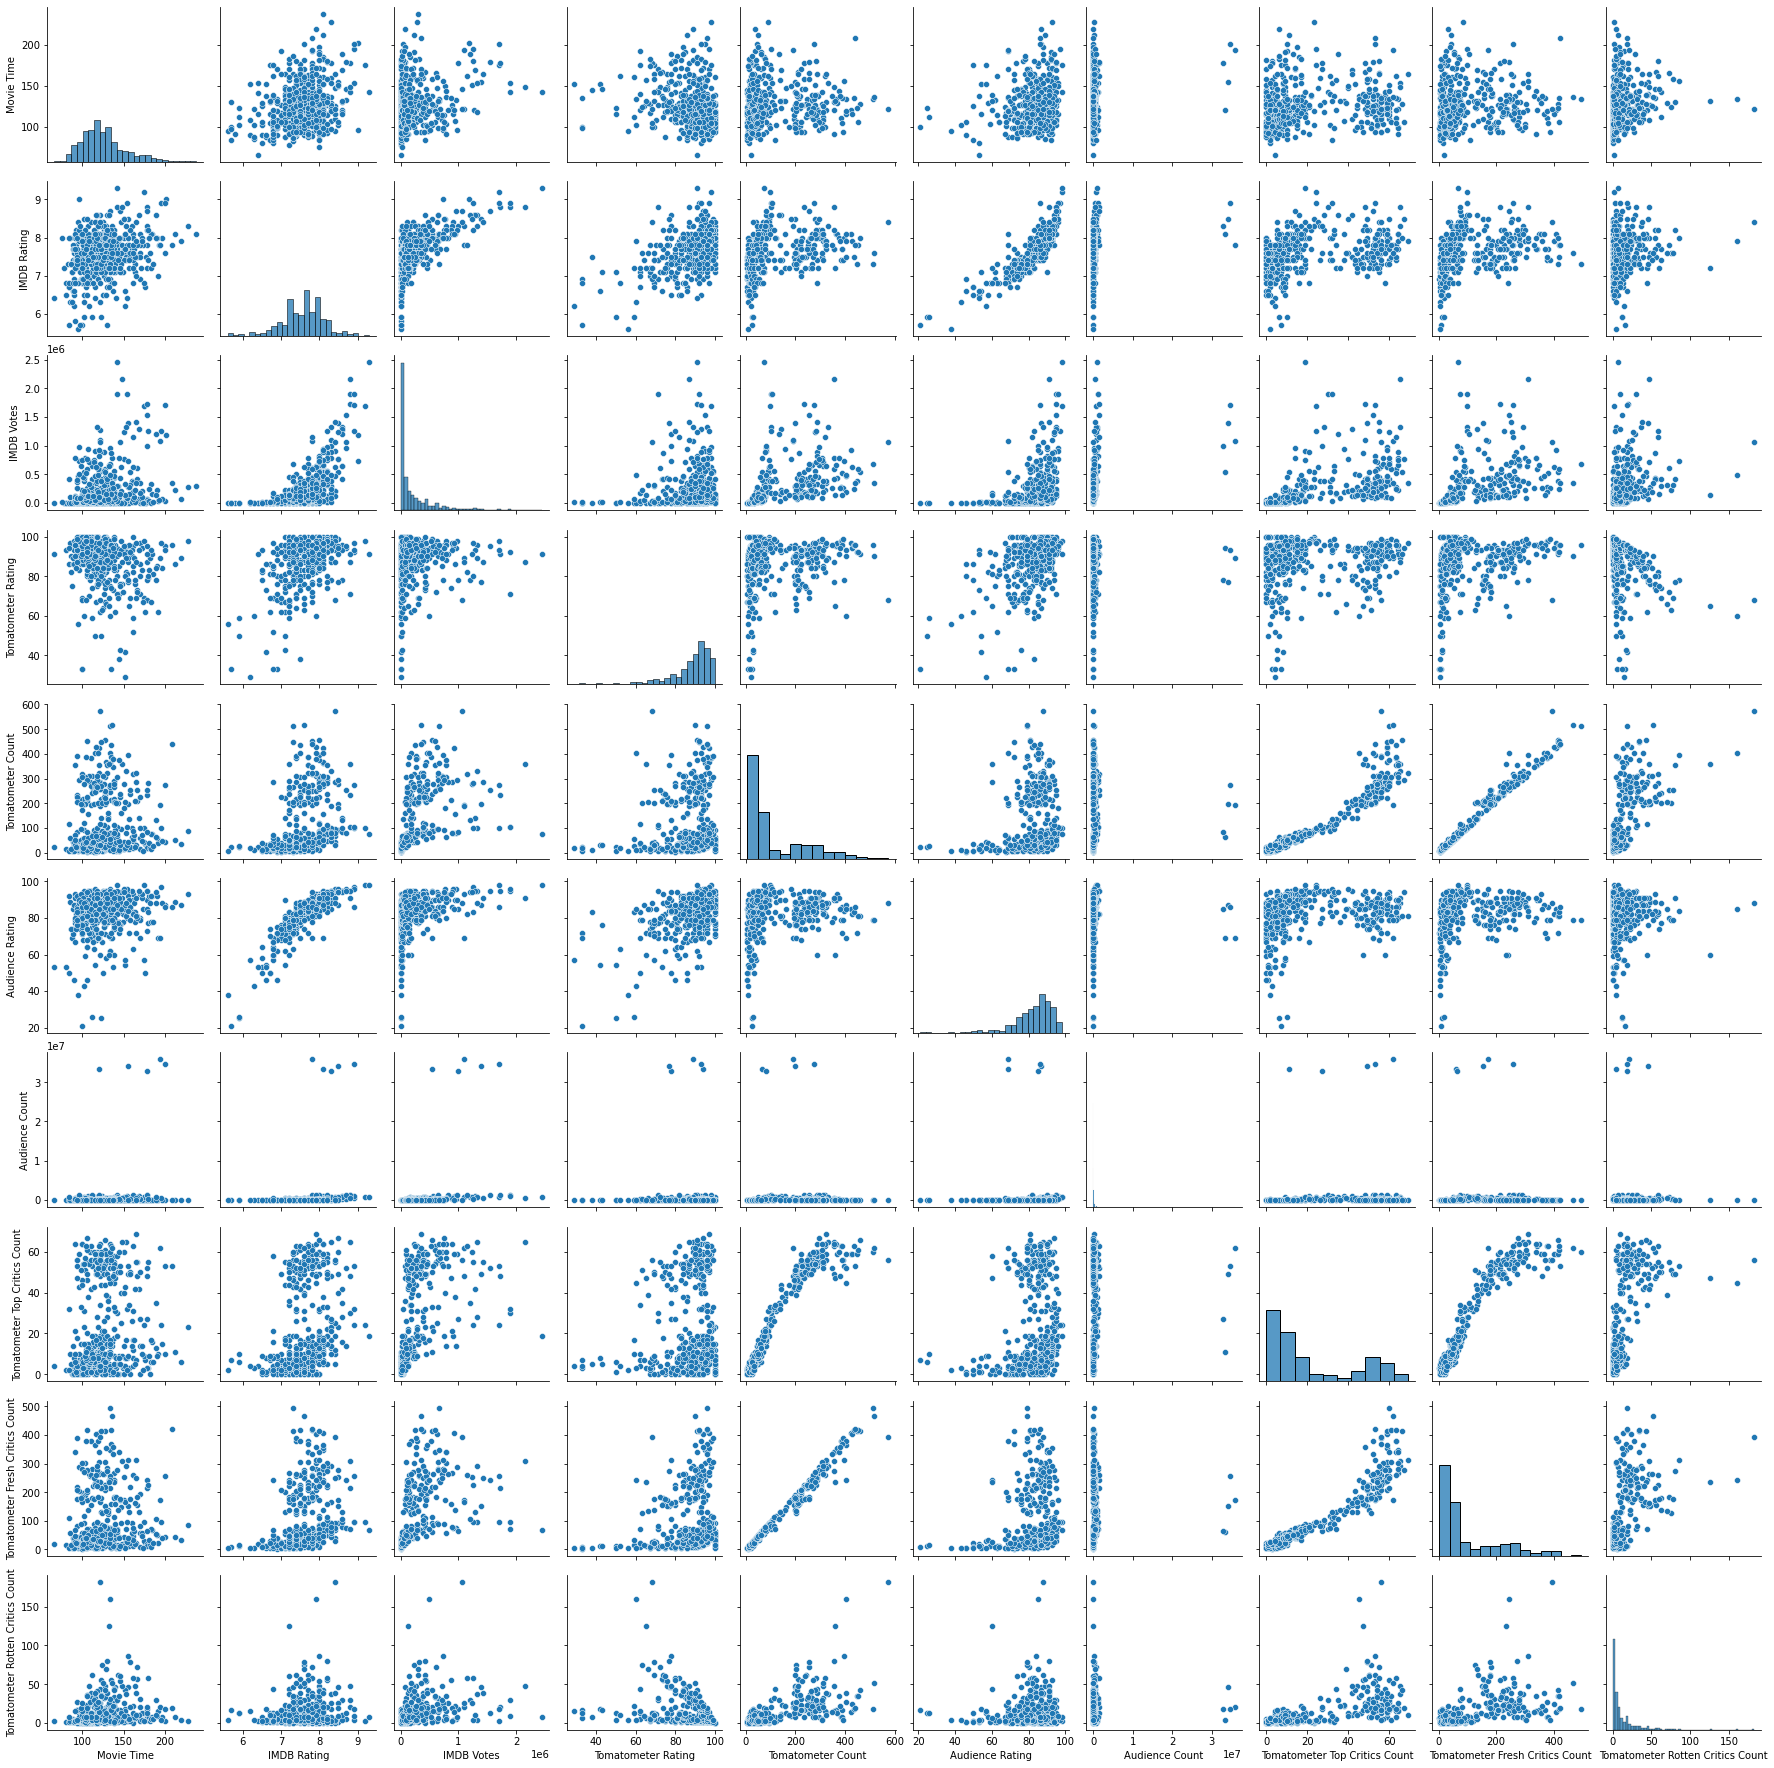

In [44]:
sns.pairplot(oscars[DIGIT_FEATURES ])

In [45]:
OUT_DIGIT_FEATURES = [
    'Tomatometer Count',
    'Audience Count',
]

oscars.drop(OUT_DIGIT_FEATURES, axis=1, inplace=True)
for col in OUT_DIGIT_FEATURES:
    DIGIT_FEATURES.remove(col)

In [46]:
oscars[DIGIT_FEATURES]

,Movie Time,IMDB Rating,IMDB Votes,Tomatometer Rating,Audience Rating,Tomatometer Top Critics Count,Tomatometer Fresh Critics Count,Tomatometer Rotten Critics Count
0,144,7.5,12221.0,93.0,78.0,9.0,43.0,3.0
1,110,7.7,3439.0,NaN,NaN,NaN,NaN,NaN
2,84,6.7,1257.0,NaN,NaN,NaN,NaN,NaN
3,100,5.7,6890.0,33.0,21.0,7.0,8.0,16.0
4,91,5.8,765.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
566,131,6.9,65380.0,NaN,NaN,NaN,NaN,NaN
567,115,7.5,57976.0,NaN,NaN,NaN,NaN,NaN
568,113,7.5,122269.0,NaN,NaN,NaN,NaN,NaN
569,120,7.8,102807.0,NaN,NaN,NaN,NaN,NaN


In [47]:
oscars[DIGIT_FEATURES].mean(axis=0)

Movie Time                             124.894921
IMDB Rating                              7.570403
IMDB Votes                          208480.376532
Tomatometer Rating                      87.503417
Audience Rating                         82.428246
Tomatometer Top Critics Count           21.861048
Tomatometer Fresh Critics Count         98.471526
Tomatometer Rotten Critics Count        12.275626
dtype: float64

In [48]:
oscars[DIGIT_FEATURES].fillna(
    oscars[DIGIT_FEATURES].mean(axis=0)
)

,Movie Time,IMDB Rating,IMDB Votes,Tomatometer Rating,Audience Rating,Tomatometer Top Critics Count,Tomatometer Fresh Critics Count,Tomatometer Rotten Critics Count
0,144,7.5,12221.0,93.000000,78.000000,9.000000,43.000000,3.000000
1,110,7.7,3439.0,87.503417,82.428246,21.861048,98.471526,12.275626
2,84,6.7,1257.0,87.503417,82.428246,21.861048,98.471526,12.275626
3,100,5.7,6890.0,33.000000,21.000000,7.000000,8.000000,16.000000
4,91,5.8,765.0,87.503417,82.428246,21.861048,98.471526,12.275626
...,...,...,...,...,...,...,...,...
566,131,6.9,65380.0,87.503417,82.428246,21.861048,98.471526,12.275626
567,115,7.5,57976.0,87.503417,82.428246,21.861048,98.471526,12.275626
568,113,7.5,122269.0,87.503417,82.428246,21.861048,98.471526,12.275626
569,120,7.8,102807.0,87.503417,82.428246,21.861048,98.471526,12.275626


In [49]:
oscars[DIGIT_FEATURES] = oscars[DIGIT_FEATURES].fillna(
    oscars[DIGIT_FEATURES].mean(axis=0)
)

---

Посмотрим так же на распределение этих факторов в срезе `Award`

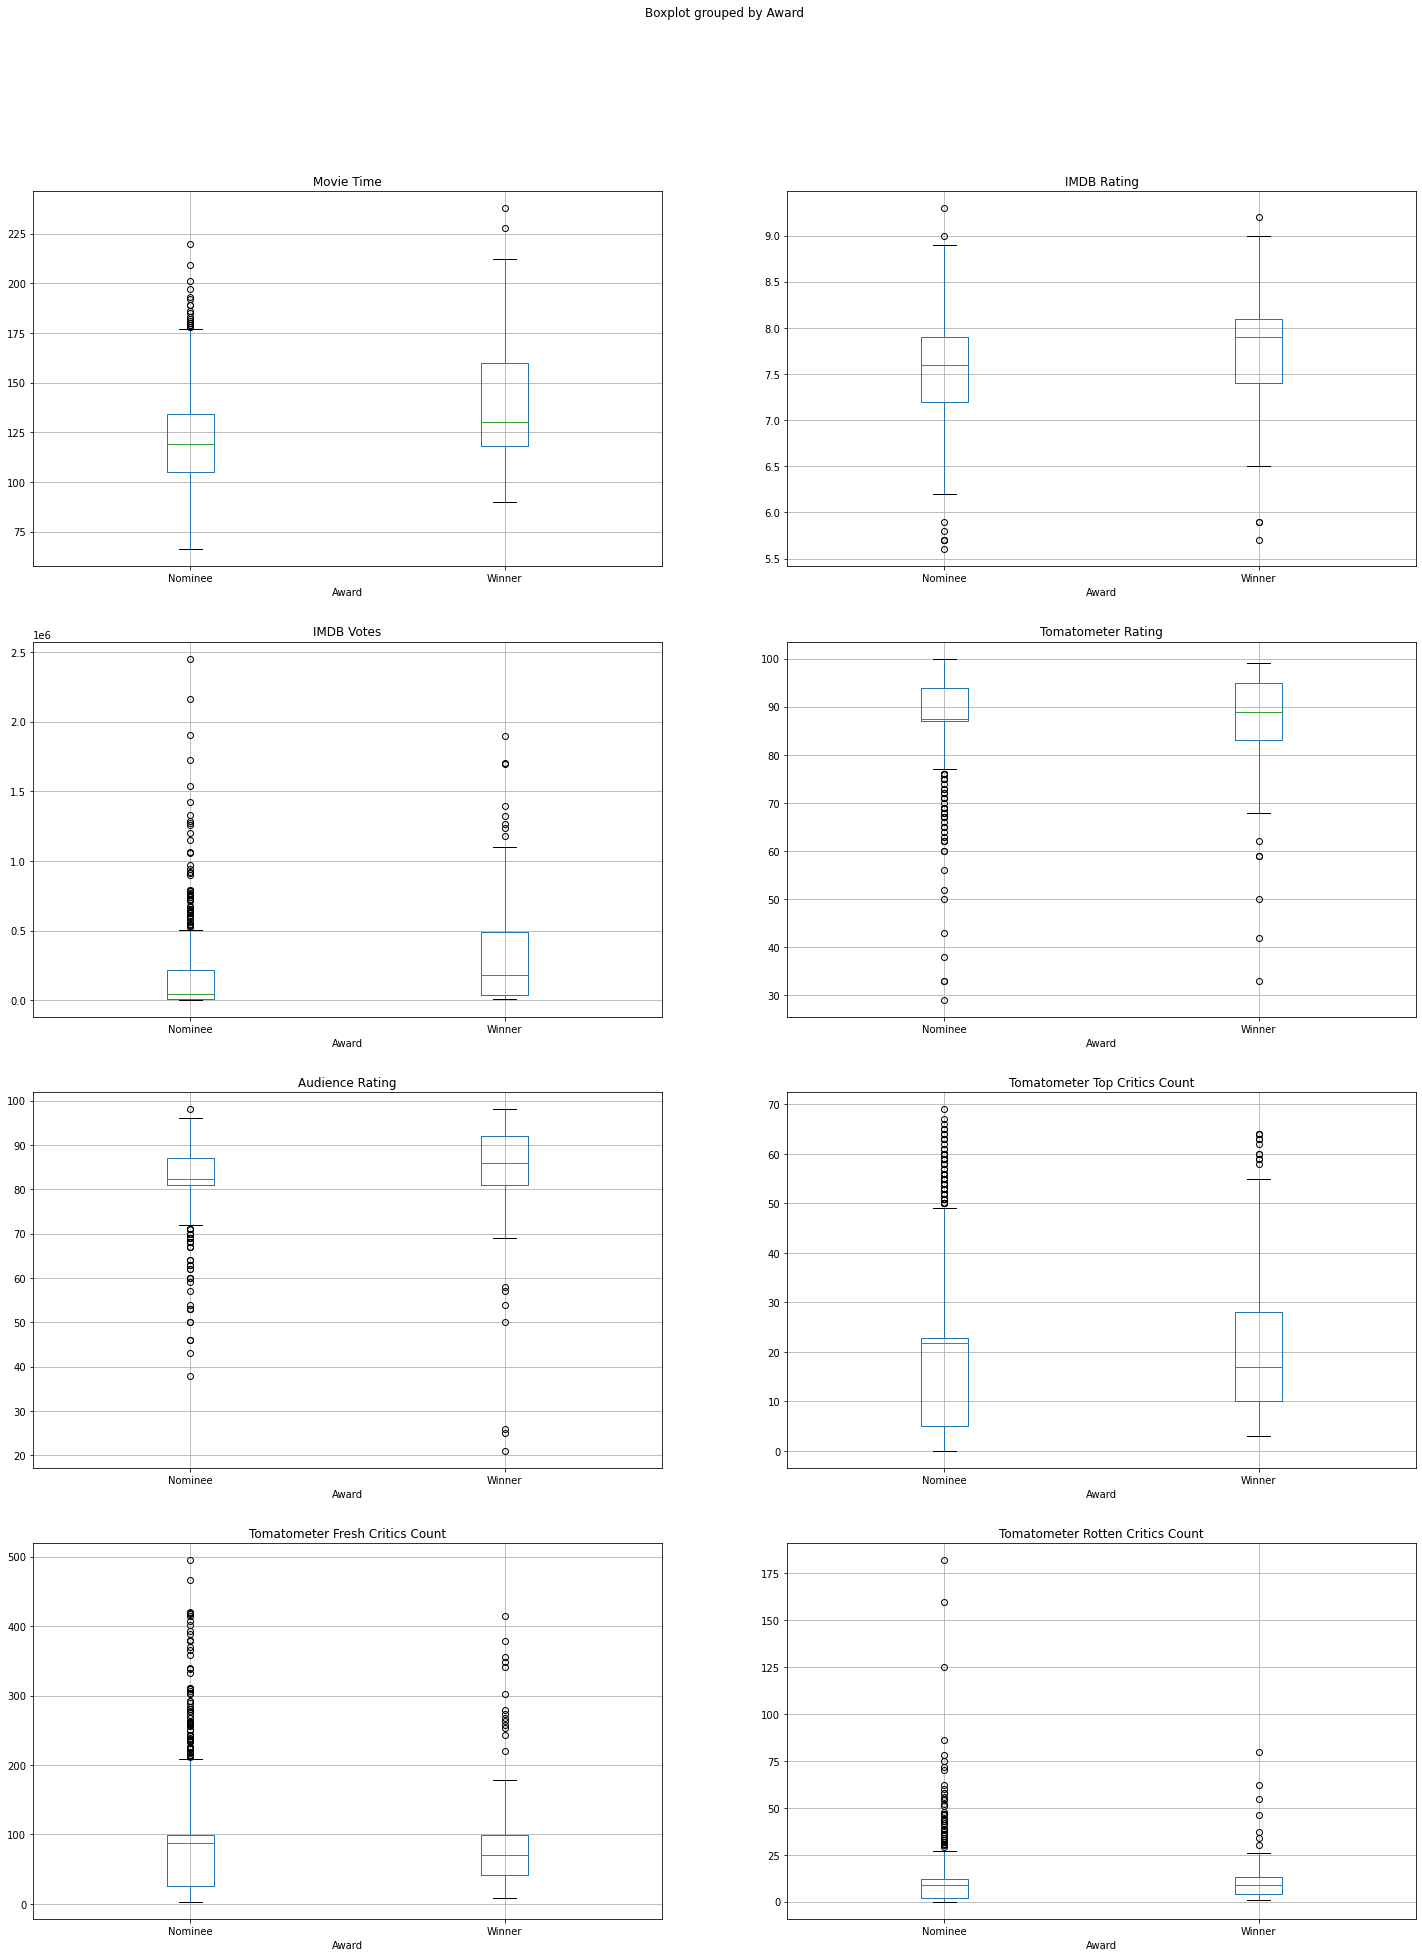

In [50]:
NROWS, NCOLS = 4, 2
plt.figure(figsize=(12 * NCOLS, 8 * NROWS))


for i, col in enumerate(DIGIT_FEATURES):
    ax = plt.subplot(NROWS, NCOLS, i + 1)
    oscars.boxplot(col, by='Award', ax=ax)

---

In [51]:
digit_mean = oscars[DIGIT_FEATURES].mean(axis=0)
digit_std = oscars[DIGIT_FEATURES].std(axis=0)

In [52]:
oscars[DIGIT_FEATURES] = (oscars[DIGIT_FEATURES] - digit_mean) / digit_std

In [53]:
oscars[DIGIT_FEATURES]

,Movie Time,IMDB Rating,IMDB Votes,Tomatometer Rating,Audience Rating,Tomatometer Top Critics Count,Tomatometer Fresh Critics Count,Tomatometer Rotten Critics Count
0,0.725799,-0.125797,-0.573271,5.363590e-01,-0.462270,-6.787527e-01,-5.870263e-01,-5.479692e-01
1,-0.565856,0.231568,-0.598923,1.248031e-14,0.000000,-1.312482e-15,7.519304e-16,-6.296430e-16
2,-1.553592,-1.555258,-0.605297,1.248031e-14,0.000000,-1.312482e-15,7.519304e-16,-6.296430e-16
3,-0.945754,-3.342083,-0.588843,-5.318467e+00,-6.412567,-7.843044e-01,-9.574131e-01,2.200220e-01
4,-1.287663,-3.163400,-0.606734,1.248031e-14,0.000000,-1.312482e-15,7.519304e-16,-6.296430e-16
...,...,...,...,...,...,...,...,...
566,0.231931,-1.197893,-0.417995,1.248031e-14,0.000000,-1.312482e-15,7.519304e-16,-6.296430e-16
567,-0.375907,-0.125797,-0.439622,1.248031e-14,0.000000,-1.312482e-15,7.519304e-16,-6.296430e-16
568,-0.451886,-0.125797,-0.251822,1.248031e-14,0.000000,-1.312482e-15,7.519304e-16,-6.296430e-16
569,-0.185957,0.410250,-0.308671,1.248031e-14,0.000000,-1.312482e-15,7.519304e-16,-6.296430e-16


### Multilabel Features

Самая интересная часть - категориальные факторы с множественным вхождением


Заметим, что тут история аналогична категориальным факторам: маломощные категории несут мало информации и их можно скластеризовать в одну группу.


Давайте для каждого фактора выделим топK-встречаемых значений и будет для каждого примера в датасете поддерживать его маску вхождения в этот top.

In [54]:
oscars[MULTILABEL_FEATURES]

,Movie Genre,Genres,Directors,Authors,Actors
0,"Drama,Romance,War","Action & Adventure, Classics",William Wellman,"Hope Loring, Louis D. Lighton","Clara Bow, Charles 'Buddy' Rogers, Richard Arl..."
1,"Drama,Romance",NaN,NaN,NaN,NaN
2,"Crime,Drama,Film-Noir",NaN,NaN,NaN,NaN
3,"Drama,Musical,Romance","Musical & Performing Arts, Romance",Harry Beaumont,"James Gleason, Norman Houston, Sarah Y. Mason","Anita Page, Bessie Love, Charles King, Jed Pro..."
4,"Action,Crime,Romance",NaN,NaN,NaN,NaN
...,...,...,...,...,...
566,"Biography,Comedy,Drama",NaN,NaN,NaN,NaN
567,Drama,NaN,NaN,NaN,NaN
568,"Crime,Drama,Thriller",NaN,NaN,NaN,NaN
569,"Drama,Music",NaN,NaN,NaN,NaN


In [55]:
def multilabel_splitter(line, sep=','):
    if type(line) != str:
        return list()
    
    line = line.strip()
    return [val.strip() for val in line.split(sep)]


def process_multilabel_column(data, column, k=20, sep=','):
    values = np.hstack(data[column].apply(lambda line: multilabel_splitter(line, sep)).values)
    values, counts = np.unique(values, return_counts=True)
    
    _draw_topk_freqs(values, counts, k, f'Top{k} {column} frequencies')
    top_values = values[np.argsort(counts)][-k:]
    
    multilabel_columns = [column +'  | ' + col for col in top_values]
    data[multilabel_columns] = np.vstack(data[column].apply(
        lambda line: np.in1d(top_values, multilabel_splitter(line, sep))
    ).values)
    return multilabel_columns

---

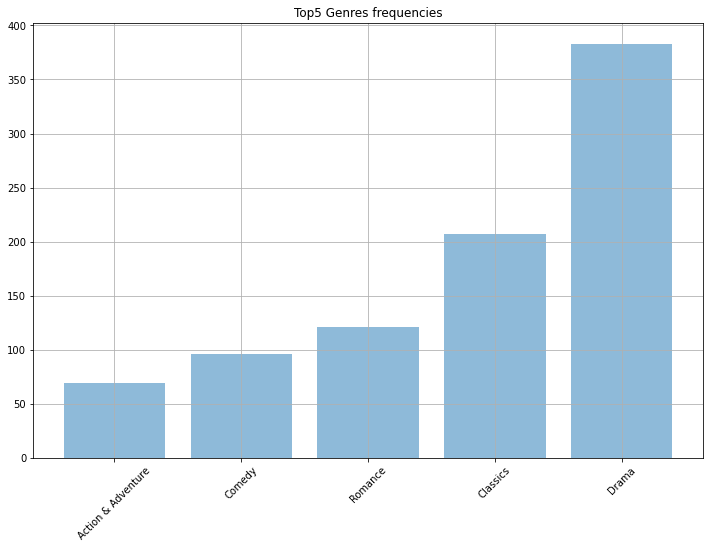

In [56]:
genres_cols = process_multilabel_column(oscars, 'Genres', 5)

MULTILABEL_FEATURES += genres_cols
MULTILABEL_FEATURES.remove('Genres')
oscars.drop('Genres', axis=1, inplace=True)

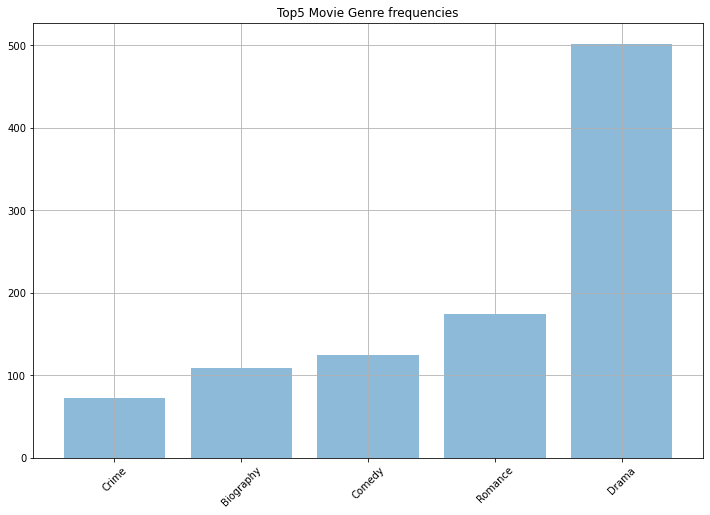

In [57]:
genres_cols = process_multilabel_column(oscars, 'Movie Genre', 5)

MULTILABEL_FEATURES += genres_cols
MULTILABEL_FEATURES.remove('Movie Genre')
oscars.drop('Movie Genre', axis=1, inplace=True)

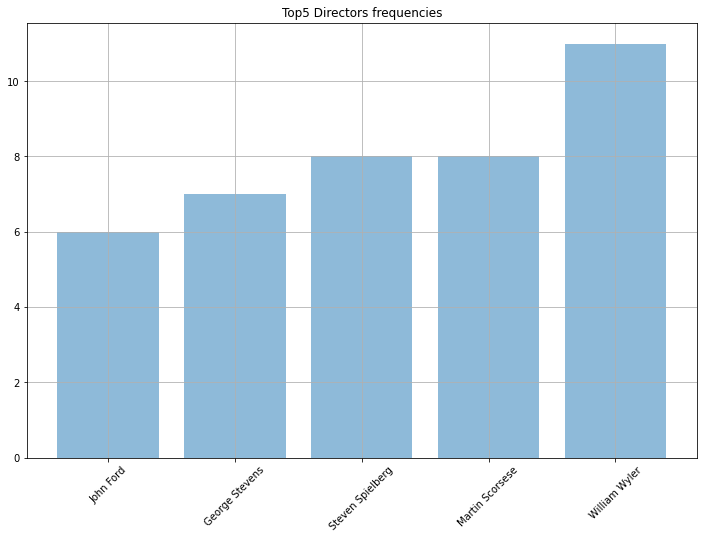

In [58]:
cols = process_multilabel_column(oscars, 'Directors', 5)

MULTILABEL_FEATURES += cols
MULTILABEL_FEATURES.remove('Directors')
oscars.drop('Directors', axis=1, inplace=True)

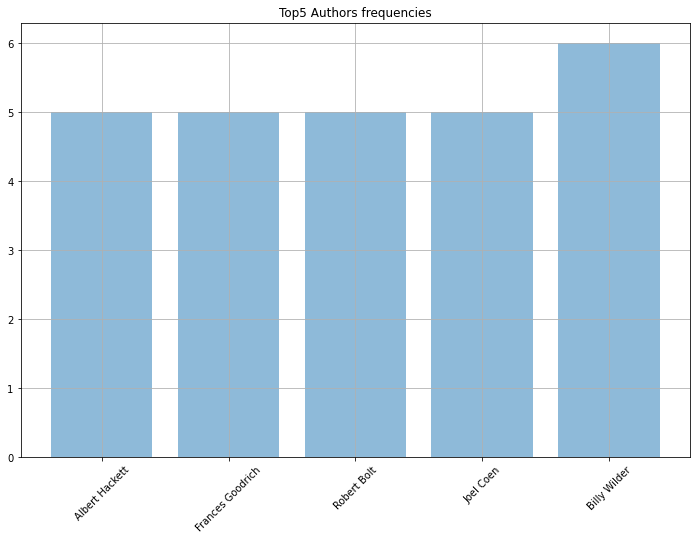

In [59]:
cols = process_multilabel_column(oscars, 'Authors', 5)

MULTILABEL_FEATURES += cols
MULTILABEL_FEATURES.remove('Authors')
oscars.drop('Authors', axis=1, inplace=True)

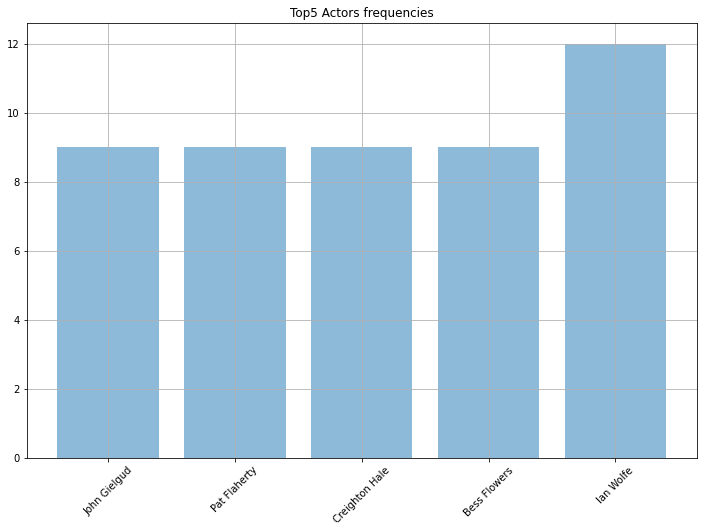

In [60]:
cols = process_multilabel_column(oscars, 'Actors', 5)

MULTILABEL_FEATURES += cols
MULTILABEL_FEATURES.remove('Actors')
oscars.drop('Actors', axis=1, inplace=True)

In [61]:
MULTILABEL_FEATURES

['Genres  | Action & Adventure',
 'Genres  | Comedy',
 'Genres  | Romance',
 'Genres  | Classics',
 'Genres  | Drama',
 'Movie Genre  | Crime',
 'Movie Genre  | Biography',
 'Movie Genre  | Comedy',
 'Movie Genre  | Romance',
 'Movie Genre  | Drama',
 'Directors  | John Ford',
 'Directors  | George Stevens',
 'Directors  | Steven Spielberg',
 'Directors  | Martin Scorsese',
 'Directors  | William Wyler',
 'Authors  | Albert Hackett',
 'Authors  | Frances Goodrich',
 'Authors  | Robert Bolt',
 'Authors  | Joel Coen',
 'Authors  | Billy Wilder',
 'Actors  | John Gielgud',
 'Actors  | Pat Flaherty',
 'Actors  | Creighton Hale',
 'Actors  | Bess Flowers',
 'Actors  | Ian Wolfe']

In [62]:
oscars[MULTILABEL_FEATURES]

,Genres | Action & Adventure,Genres | Comedy,Genres | Romance,Genres | Classics,Genres | Drama,Movie Genre | Crime,Movie Genre | Biography,Movie Genre | Comedy,Movie Genre | Romance,Movie Genre | Drama,...,Authors | Albert Hackett,Authors | Frances Goodrich,Authors | Robert Bolt,Authors | Joel Coen,Authors | Billy Wilder,Actors | John Gielgud,Actors | Pat Flaherty,Actors | Creighton Hale,Actors | Bess Flowers,Actors | Ian Wolfe
0,True,False,False,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,False,False,False,False,False,False,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
567,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
568,False,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
569,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


---

Таким образом, мы свели наш исходный сырой датасет к работоспособному виду

Единственное, что осталось не тронутым - это текстовые факторы и `Film ID`

Обработка текстовых факторов несколько выходит за рамки этого курса, поэтому в данном семинаре мы их просто опустим
А любые айдишники - это просто некоторый уникальный хэш сэмпла датасета, который только мешает обучению моделей машинного обучения. Так как склоняет их к меморизации выборки, вместо построения обобщений

In [64]:
oscars

,Film,Oscar Year,Film Studio/Producer(s),Award,Year of Release,Movie Time,IMDB Rating,IMDB Votes,Movie Info,Critic Consensus,...,Authors | Albert Hackett,Authors | Frances Goodrich,Authors | Robert Bolt,Authors | Joel Coen,Authors | Billy Wilder,Actors | John Gielgud,Actors | Pat Flaherty,Actors | Creighton Hale,Actors | Bess Flowers,Actors | Ian Wolfe
0,Wings,1927,_rest,Winner,1927,0.725799,-0.125797,-0.573271,"With World War I afoot, David Armstrong (Richa...",Subsequent war epics may have borrowed heavily...,...,False,False,False,False,False,False,False,False,False,False
1,7th Heaven,1927,Fox,Nominee,1927,-0.565856,0.231568,-0.598923,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
2,The Racket,1927,_rest,Nominee,1928,-1.553592,-1.555258,-0.605297,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
3,The Broadway Melody,1928,Metro-Goldwyn-Mayer,Winner,1929,-0.945754,-3.342083,-0.588843,"Vaudeville sisters ""Hank"" (Bessie Love) and Qu...",The Broadway Melody is interesting as an examp...,...,False,False,False,False,False,False,False,False,False,False
4,Alibi,1928,_rest,Nominee,1929,-1.287663,-3.163400,-0.606734,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,Mank,2020,_rest,Nominee,2020,0.231931,-1.197893,-0.417995,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
567,Minari,2020,_rest,Nominee,2020,-0.375907,-0.125797,-0.439622,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
568,Promising Young Woman,2020,_rest,Nominee,2020,-0.451886,-0.125797,-0.251822,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
569,Sound of Metal,2020,_rest,Nominee,2019,-0.185957,0.410250,-0.308671,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
